## Visualize

### Plot data

In [24]:
import h5py
import numpy as np
import os

import sys
sys.path.append('..')
from util.plotting import plot_image_rows



def get_path(model_sim, ws, encoded, norm):
    if model_sim == "p21c":
        dp = f"/users/jsolt/data/jsolt/21cmFAST_sims/p21c14/p21c14"
    elif model_sim == "zreion":
        dp = f"/users/jsolt/data/jsolt/zreion_sims/zreion24/zreion24"
    elif model_sim == "ctrpx":
        dp = f"/users/jsolt/data/jsolt/centralpix_sims/centralpix05/centralpix05"
    if encoded:
        dp += f"_norm_encoded_ws{ws}.hdf5" if norm else f"_encoded_ws{ws}.hdf5"
    else:
        dp += f"_subdiv_sliced_ws{ws}.hdf5"
    return dp
 

sim = "ctrpx"
ws = 0.0

unenc_fname = get_path(sim, ws, False, False)
enc_fname = get_path(sim, ws, True, False)
norm_enc_fname = get_path(sim, ws, True, True)

fig_dir = f"../figures/data_figures/{sim}_ws{ws}"
if not os.path.exists(fig_dir): os.mkdir(fig_dir)

start, end = 0,8
ntrvl=4
n = np.arange(start*ntrvl,end*ntrvl,ntrvl)
z = np.linspace(0, 29, 6, dtype=int)



In [25]:

with h5py.File(enc_fname, 'r') as f:
    print(f['lightcones/brightness_temp'].shape)
    print(f['lightcone_params/physparams'].shape)
    sample = f['lightcones/brightness_temp'][n]
    labels = f['lightcone_params/physparams'][n]

sample = sample[:,z]
print(sample.shape)
print(labels.shape)


(3445, 30, 4, 32, 32)
(3445, 3)
(8, 6, 4, 32, 32)
(8, 3)


In [26]:

%matplotlib inline

for c in range(4):
    rowdict = {f"lc {ni} dur {labels[ni,1]:.1f}":sample[ni,:,c,:,:] for ni in range(len(n))}
    plot_image_rows(rowdict, fname=f"{fig_dir}/latent_channel_{c}_{sim}_ws{ws}.jpg", title=f"{sim} ws={ws} encoded channel {c}")


In [27]:
with h5py.File(norm_enc_fname, 'r') as f:
    print(f['lightcones/brightness_temp'].shape)
    print(f['lightcone_params/physparams'].shape)
    sample = f['lightcones/brightness_temp'][n]
    labels = f['lightcone_params/physparams'][n]

sample = sample[:,z]
print(sample.shape)
print(labels.shape)

(3445, 30, 4, 32, 32)
(3445, 3)
(8, 6, 4, 32, 32)
(8, 3)


In [28]:
%matplotlib inline

for c in range(4):
    rowdict = {f"lc {ni} dur {labels[ni,1]:.1f}":sample[ni,:,c,:,:] for ni in range(len(n))}
    plot_image_rows(rowdict, fname=f"{fig_dir}/prenorm_latent_channel_{c}_{sim}_ws{ws}.jpg", title=f"{sim} ws={ws} prenorm encoded channel {c}")

In [29]:

with h5py.File(unenc_fname, 'r') as f:
    print(f['lightcones/brightness_temp'].shape)
    input = f['lightcones/brightness_temp'][n]
    labels = f['lightcone_params/physparams'][n]
input = input[:,z]
print(input.shape)

(3445, 30, 256, 256)
(8, 6, 256, 256)


In [30]:
%matplotlib inline

rowdict = {f"lc {ni} dur {labels[ni,1]:.1f})":input[ni,:,:,:] for ni in range(len(n))}

plot_image_rows(rowdict, fname=f"{fig_dir}/unencoded_bT_{sim}_ws{ws}.jpg", title=f"{sim} ws={ws} unencoded bT")


### Dataset Statistics

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt

get_name = {
    "p21c" : "p21c14",
    "zreion" : "zreion24",
    "ctrpx" : "centralpix05"
    }

get_dir = {
    "p21c" : "/users/jsolt/data/jsolt/21cmFAST_sims",
    "zreion" : "/users/jsolt/data/jsolt/zreion_sims",
    "ctrpx" : "/users/jsolt/data/jsolt/centralpix_sims"
    }

npz_fname, fig_dir = {}, {}
sims = ["p21c", "ctrpx", "zreion"]
ws = 0.0

npz_fname = {sim:f"{get_dir[sim]}/{get_name[sim]}/{get_name[sim]}_ws{ws}_vae_stats.npz" for sim in sims}

fig_dir = "../figures/data_figures"

In [32]:
npz = {sim: np.load(npz_fname[sim]) for sim in sims}


FileNotFoundError: [Errno 2] No such file or directory: '/users/jsolt/data/jsolt/21cmFAST_sims/p21c14/p21c14_ws0.0_vae_stats.npz'

#### MSE

In [ ]:
%matplotlib inline

fig, ax = plt.subplots()
ax.set_title("MSE: Original v. Decoded ")
ax.set_ylabel("Mean MSE")
ax.set_xlabel("z slice index")

for sim in sims:
    stat = npz[sim]['mse'].mean(axis=0)

    ax.grid(True)
    ax.plot(stat, label=sim)

ax.legend()
plt.savefig(f"{fig_dir}/mean_mse_per_z.jpeg")
#plt.show()
plt.clf()

#### Corrcoef

In [ ]:
%matplotlib inline

fig, ax = plt.subplots()
ax.set_title("Cross-Correlation: Original v. Decoded ")
ax.set_ylabel("Mean diag(cc matrix)")
ax.set_xlabel("z slice index")

for sim in sims:
    stat = np.nanmean(npz[sim]['corrcoef'], axis=0)

    ax.grid(True)
    ax.plot(stat, label=sim)

ax.legend()
plt.savefig(f"{fig_dir}/mean_cc_per_z.jpeg")
#plt.show()
plt.clf()

### Visualizing Soft Label Accuracy

In [ ]:
import torch
import numpy as np
import glob
import py21cmfast as p21c
import matplotlib.pyplot as plt
from astropy.cosmology import z_at_value
import astropy.units as u


In [ ]:
lcdir = "/users/jsolt/data/jsolt/lightcones/21cmFAST_lightcones_centralpix_v05/*.h5"
lclist = glob.glob(lcdir)
lcindex = 3
fname = lclist[lcindex]
#0,3,4
lightcone = p21c.outputs.LightCone.read(fname)

print(lightcone.__dict__.keys())


Finding Redshift Values

In [ ]:
lightcone_distances = lightcone.lightcone_distances*u.Mpc

lightcone_redshifts = np.array([
    z_at_value(lightcone.cosmo_params.cosmo.comoving_distance, d) for d in lightcone_distances
])

Find true parameters

In [ ]:
xH_cube = lightcone.lightcones['xH_box']

node_z = lightcone.node_redshifts
global_xH = lightcone.global_xH

true_zpoints = np.interp([0.25, 0.75], np.flip(global_xH), np.flip(node_z))
true_dur = true_zpoints[-1] - true_zpoints[0]
print(true_zpoints)
print(true_dur)

Estimate parameters for a sliced lightcone

In [ ]:
redshifts = lightcone.lightcone_redshifts

old_z = 512
new_z = 30
zslice_inds = np.linspace(0, old_z-1, new_z, dtype=int) #recreating how I slice them when I process them

zslice_redshifts = redshifts[zslice_inds]

sliced_bT = lightcone.lightcones['brightness_temp'][:,:,zslice_inds]
xH_regions = np.where(sliced_bT == 0.0, 0, 1)
est_global_xH = np.mean(xH_regions, axis=(0,1))

est_zpoints = np.interp([0.25, 0.75], est_global_xH, zslice_redshifts)
est_dur = est_zpoints[-1] - est_zpoints[0]
print(est_zpoints)
print(est_dur)

Let's look at how our estimate of the xH compares to the true map:

In [ ]:
z=20

fig, ax = plt.subplots(1, 3, sharey=True, layout="constrained")
ax1, ax2, ax3 = ax

true_xH_regions = lightcone.lightcones['xH_box'][:,:,zslice_inds]

ax1.imshow(sliced_bT[:,:,z])
ax1.set_title("Brightness temp")

ax2.imshow(xH_regions[:,:,z])
ax2.set_title("Estimated xH")

ax3.imshow(true_xH_regions[:,:,z])
ax3.set_title("True xH")

plt.show()
plt.close()

In [ ]:
'''
redshift_span = redshifts[-1]-redshifts[0]

fig, axs = plt.subplots(2, 1, sharex=True, layout="constrained")
ax1, ax2 = axs


ax1.set_title(f"Lightcone {lcindex}:")
xind = 0
ax1.imshow(xH_cube[xind,:,:], extent=[0,redshift_span,0,1], aspect=redshift_span/2)
ax1.axes.get_yaxis().set_visible(False)
'''
ax = plt.subplot()


ax.plot(node_z, global_xH, label="True Global xH", color='red')
ax.plot(redshifts[zslice_inds], est_global_xH, label="Estimated Global xH", color='blue')

for pt in true_zpoints:
    ax.axvline((pt), color='red', ls=":", alpha=0.5)

for pt in est_zpoints:
    ax.axvline((pt), color='blue', ls=":", alpha=0.5)




ax.set_ylim(0.0, 1.0)
ax.set_yticks(np.arange(0.0, 1.25, 0.25))
ax.set_yticklabels([])

#asp = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
#ax2.set_aspect(asp/2)

#n=5
#ax.set_xticks(np.linspace(redshifts[0], redshifts[-1], n), np.linspace(redshifts[0], redshifts[-1], n).round(1))

ax.set_title(f"True Duration = {true_dur:2.2f}, Est. Duration = {est_dur:2.2f}")



ax.grid(True)
ax.legend()

plt.show()
plt.close()

## Counterfactuals

In [1]:
import h5py
import matplotlib
import os
import sys
sys.path.append('..')
from util.plotting import plot_histogram

In [2]:
model_names = {
        "p21c":"cnn_v03_p21c_ws0.0_2025-02-28T12-28",
        "ctrpx":"cnn_v03_ctrpx_ws0.0_2025-02-28T12-28",
        "zreion":"cnn_v03_zreion_ws0.0_2025-02-28T12-32"
}

cf_version = "10"

save_dir = f"/users/jsolt/data/jsolt/counterfactuals"

def get_cf_path(sim):
    return f"{save_dir}/{model_names[sim]}_counterfactuals_{cf_version}.hdf5"


### Counterfactual Parameter Histograms

In [3]:
sim = "ctrpx"

cf_path = get_cf_path(sim)

datadict = {}

with h5py.File(cf_path) as f:
    print(f['lightcone_params'].keys())
    print(len(f['lightcones/x_prime']))
    datadict['y'] = f['lightcone_params/y'][:]
    datadict['y_prime'] = f['lightcone_params/y_prime'][:]

<KeysViewHDF5 ['y', 'y_prime', 'y_true']>
3000


In [43]:
fig_dir= f"../figures/counterfactual_figures/counterfactuals_{cf_version}"
if not os.path.exists(fig_dir): os.mkdir(fig_dir)
nbins = 100

figname = f"{fig_dir}/{model_names[sim]}_counterfactuals_{cf_version}_distribution_compare.jpg"
title = f"Duration histogram: {sim} counterfactuals v{cf_version} vs. data"
plot_histogram(datadict, title=title, fname=figname, nbins=nbins)

In [44]:
diffdict = {"diff": datadict['y_prime'] - datadict['y']}

figname = f"{fig_dir}/{model_names[sim]}_counterfactuals_{cf_version}_distribution_diff.jpg"
title = f"Duration histogram: {sim} y'-y"
plot_histogram(diffdict, title=title, fname=figname, nbins=nbins)

### Visualize CF

In [51]:
sim = "ctrpx"

cf_path = get_cf_path(sim)

x_list = []
x_prime_list = []
y_prime_list = []
loss_dict ={}

lci=0


with h5py.File(cf_path) as f:
    x_list.append(f['lightcones/x'][lci])
    x_prime_list.append(f['lightcones/x_prime'][lci])

    print(f['lightcone_params/y_true'][lci])
    print(f['lightcone_params/y'][lci])
    print(f['lightcone_params/y_prime'][lci])

    loss_dict['total_loss'] = f['regression_info/total_loss'][lci]
    loss_dict['x_loss'] = f['regression_info/x_loss'][lci]
    loss_dict['y_loss'] = f['regression_info/y_loss'][lci]


1.6212313
1.6478739
26.27528


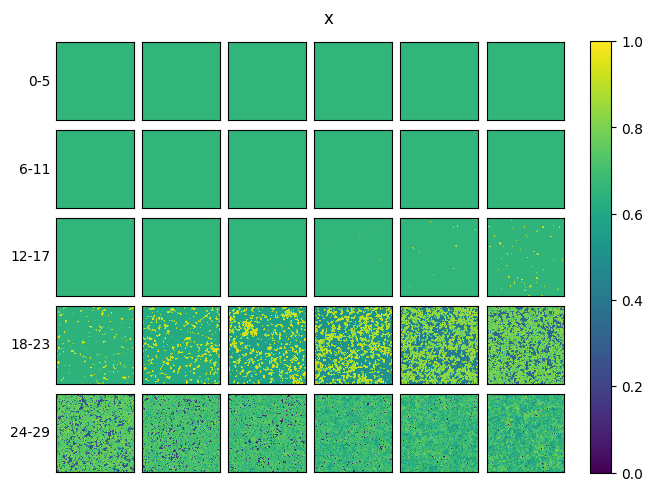

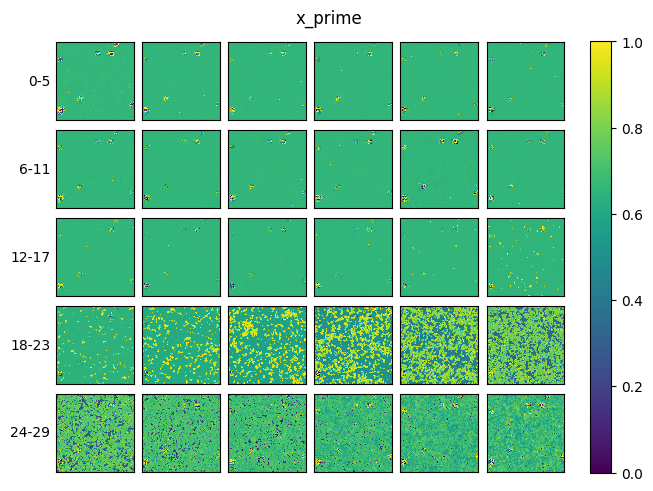

In [46]:
%matplotlib inline

from util.plotting import plot_image_grid
plot_image_grid(x_list[lci], title="x")
plot_image_grid(x_prime_list[lci], title="x_prime")

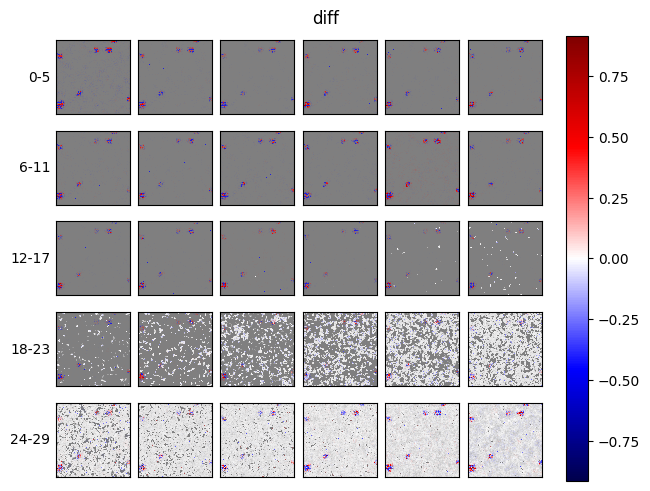

In [47]:
%matplotlib inline


from util.plotting import plot_imgrid_with_overlay


diff = x_list[lci]-x_prime_list[lci]
plot_imgrid_with_overlay(x_list[lci], diff, title="diff")


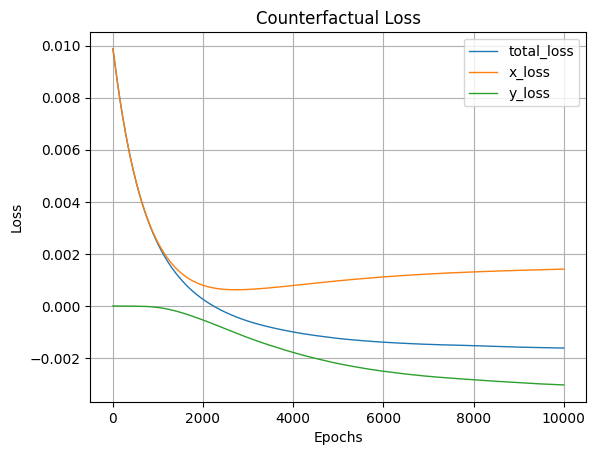

In [52]:
from util.plotting import plot_cf_loss


plot_cf_loss(loss_dict, title=f"Counterfactual Loss")
